# Consumption prediction
### Author : Nicolas Lacroix (https://github.com/NicolasLacroix)

Licence : [Apache License 2.0]

This notebook uses [consumption.ipynb] and [meteorology.ipynb].

[Apache License 2.0]: https://github.com/NicolasLacroix/data-representation/blob/master/LICENSE

[consumption.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/consumption.ipynb
[meteorology.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/meteorology.ipynb

In [1]:
import torch
import torch.nn as nn

(115233, 81)
(29003, 18)


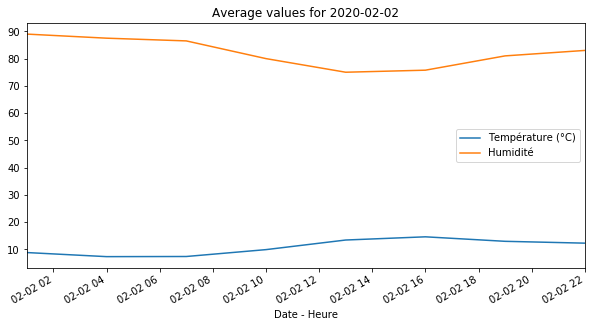

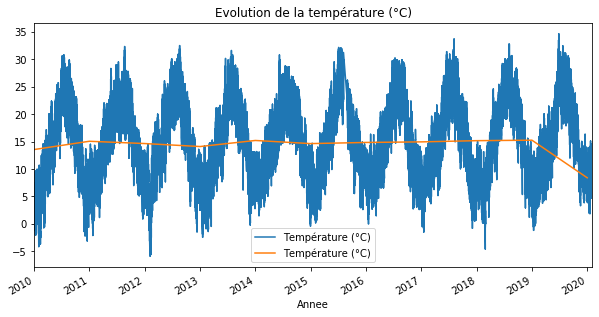

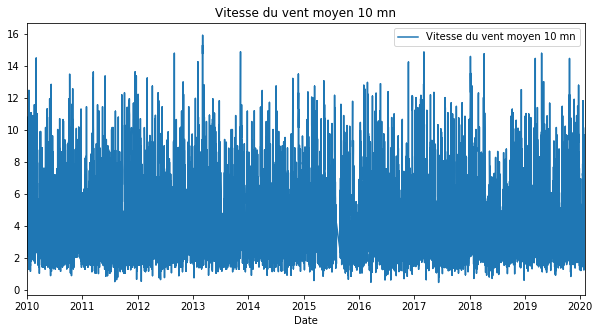

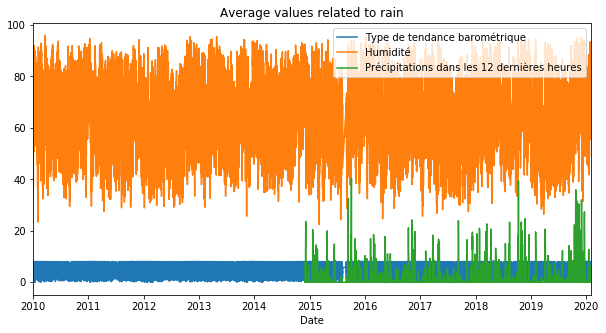

In [2]:
%run consumption.ipynb
%run meteorology.ipynb

In [3]:
def extractDate(data):
    data['Minute'] = data["Heure"].apply(lambda x : x.minute)
    data["Heure"] = data["Heure"].apply(lambda x : x.hour)
    data["Heure"] = data["Heure"].values.astype(np.float64)
    data["Minute"] = data["Minute"].values.astype(np.float64)
    return data

In [4]:
# scaling the training data
TRAIN_SPLIT = 400 # size of the training dataset
#data_train = data[["Consommation (MW)", "Date", "Heure"]][:TRAIN_SPLIT]
data_train = data[["Heure"]][:TRAIN_SPLIT]
#data_train_mean = data_train["Consommation (MW)"].mean()
#data_train_std = data_train["Consommation (MW)"].std()
#data_train["Consommation (MW)"] = (data_train["Consommation (MW)"]-data_train_mean)/data_train_std
# converting date and time
#data_train["Date"] = data_train["Date"].values.astype(np.float64)
"""data_train['Minute'] = data_train["Heure"].apply(lambda x : x.minute)
data_train["Heure"] = data_train["Heure"].apply(lambda x : x.hour)
data_train["Heure"] = data_train["Heure"].values.astype(np.float64)
data_train["Minute"] = data_train["Minute"].values.astype(np.float64)"""
data_train = extractDate(data_train)
data_train

,Heure,Minute
0,1.0,30.0
1,2.0,0.0
2,2.0,15.0
3,2.0,45.0
4,4.0,0.0
...,...,...
395,16.0,30.0
396,17.0,15.0
397,20.0,0.0
398,20.0,30.0


In [5]:
# data.merge(data_meteo, on="Date", how="left")
data_meteo['Date'] = pd.to_datetime(data_meteo['Date'])
print(data.dtypes)
data_meteo.dtypes

Code INSEE région                                     int64
Région                                               object
Nature                                               object
Date                                         datetime64[ns]
Heure                                                object
Date - Heure           datetime64[ns, pytz.FixedOffset(60)]
Consommation (MW)                                   float64
Thermique (MW)                                      float64
Nucléaire (MW)                                      float64
Eolien (MW)                                         float64
Solaire (MW)                                        float64
Hydraulique (MW)                                    float64
Pompage (MW)                                        float64
Bioénergies (MW)                                    float64
Ech. physiques (MW)                                 float64
TCO Thermique (%)                                   float64
TCH Thermique (%)                       

Date                                           datetime64[ns]
Annee                                                   int64
Heure                                                  object
Date - Heure                                           object
Pression au niveau mer                                float64
Variation de pression en 3 heures                     float64
Type de tendance barométrique                         float64
Direction du vent moyen 10 mn                         float64
Vitesse du vent moyen 10 mn                           float64
Point de rosée                                        float64
Humidité                                              float64
Temps présent                                         float64
Pression station                                      float64
Rafales sur une période                               float64
Periode de mesure de la rafale                        float64
Précipitations dans la dernière heure                 float64
Précipit

In [6]:
# data.loc(data["Date"] == data_meteo["Date"])
data_train_test = data[:TRAIN_SPLIT]
data_train_meteo = data_meteo[:TRAIN_SPLIT]
data_train_test.sort_index(inplace=True)
data_train_meteo.sort_index(inplace=True)
# data_train.loc(data_train["Date"] == data_train_meteo["Date"])
data_train_test['Date'] == data_train_meteo['Date']

0      False
1      False
2      False
3      False
4      False
       ...  
395    False
396    False
397    False
398    False
399    False
Name: Date, Length: 400, dtype: bool

In [7]:
# target definition
target_data = data[["Consommation (MW)"]][:TRAIN_SPLIT]
# data_train_mean = target_data["Consommation (MW)"].mean()
# data_train_std = target_data["Consommation (MW)"].std()
# target_data["Consommation (MW)"] = (target_data["Consommation (MW)"]-data_train_mean)/data_train_std
# target_data[["Date", "Heure"]] = target_data[["Date", "Heure"]].values.astype(np.float64)
# target_data = extractDate(target_data)
target_data

,Consommation (MW)
0,4677.0
1,4653.0
2,4797.0
3,4521.0
4,4180.0
...,...
395,4620.0
396,4820.0
397,5244.0
398,5196.0


In [8]:
# number of criterias : Date - Time
nbIn = data_train.shape[1]
# neural network statistics
nbOut = 1
nbHidden = 100
# définition of the neural network
neuralNetwork = nn.Sequential(nn.Linear(nbIn,nbHidden), nn.ReLU(), nn.Linear(nbHidden,nbOut))
neuralNetwork

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [9]:
# launch criterias + optimizing options
criterion = nn.MSELoss() # MSELoss = moindres carrés
optimizer = torch.optim.SGD(neuralNetwork.parameters(), lr=0.000003) # lr = learning rate
nbEpochs = 1000 # nombre d'itérations

In [10]:
# converting data (to pytorch tensor)
input_data = torch.FloatTensor(data_train.values)
target = torch.FloatTensor(target_data.values)
#target = torch.FloatTensor(target_data.values.reshape((TRAIN_SPLIT, )))
#target = target.unsqueeze(0)

In [11]:
items = []
# launching iterations
for epoch in range(nbEpochs):
    optimizer.zero_grad() # zero_grad = ?
    output = neuralNetwork(input_data)
    loss = criterion(output, target) # calcul de la fonction cout (moindres carrés)
    loss.backward() # calcul du gradient (sens = droite vers gauche)
    optimizer.step() # ? (modification des parametres du réseau de neurones)
    print(loss.item())
    items.append(loss.item())

27362974.0
25728934.0
22674286.0
15998408.0
8638255.0
7412331.0
6910946.5
6490814.5
6133604.0
5825356.0
5561835.5
5339951.5
5156484.0
5007749.5
4889561.0
4796962.5
4725297.5
4670132.0
4627887.0
4595636.0
4570694.0
4550829.0
4534676.5
4520918.5
4508767.0
4497306.5
4486235.0
4475116.0
4463619.0
4451777.5
4439254.5
4426153.0
4412517.0
4399145.5
4386403.0
4373818.5
4361540.0
4349355.5
4337020.0
4324461.0
4311669.5
4298629.5
4285342.0
4271812.0
4258022.5
4244001.5
4229739.0
4215235.5
4200500.0
4185528.25
4170326.0
4154902.75
4139274.25
4123443.75
4107429.0
4091190.0
4074735.0
4058031.25
4041128.25
4024089.5
4006932.25
3989692.5
3972475.0
3955367.25
3938204.5
3921159.75
3904175.75
3887226.5
3870316.75
3853481.0
3836705.25
3819997.75
3803385.0
3786876.5
3770491.25
3754255.75
3738175.25
3722263.0
3706531.75
3690993.0
3675651.25
3660536.25
3645649.5
3631002.5
3616582.75
3602422.75
3588529.0
3574874.0
3561512.0
3548395.0
3535567.0
3523007.25
3510723.0
3498728.25
3487011.0
3475821.0
3464704.75
34

2676427.75
2455796.0
2673059.25
2455548.0
2698560.75
2456784.25
2644358.5
2452418.5
2740708.75
2480759.75
2688466.0
2477581.0
2790228.25
2491705.5
2698669.5
2458290.0
2697088.0
2457143.0
2716727.0
2458109.25
2696672.0
2441716.25
2651792.25
2441074.75
2758171.5
2454496.25
2649491.75
2422716.75
2681698.0
2428561.25
2664340.5
2434572.25
2725061.0
2451286.5
2701800.25
2440002.5
2705187.0
2434050.5
2716808.25
2423997.5
2654864.75
2404393.25
2651550.0
2405660.5
2679452.5
2410954.5
2690395.0
2404601.25
2656147.0
2384376.5
2613258.25
2380691.0
2688592.0
2403262.5
2660074.75
2380860.75
2632825.0
2383395.75
2688969.5
2399907.25
2698156.5
2381316.25
2598302.25
2357489.5
2646273.5
2374596.25
2685376.0
2381680.5
2655230.5
2375426.5
2635964.5
2396901.0
2833506.5
2379144.25
2480647.0
2284471.0
2600621.5
2305005.0
2515570.25
2289907.0
2584453.0
2335773.0
2695206.5
2344044.5
2568053.0
2299727.25
2585619.0
2273568.75
2416991.0
2304567.75
2855162.0
2368440.5
2473163.5
2265284.5
2581915.75
2280174.5
25030

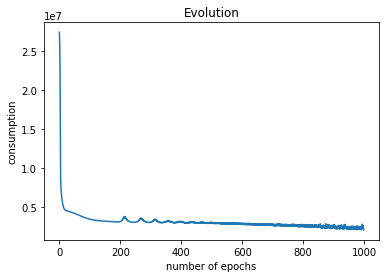

In [12]:
fig, ax = plt.subplots()
x = np.arange(len(items))
ax.plot(x, items)
ax.set(xlabel='number of epochs', ylabel='consumption',
       title='Evolution')
plt.show()